In [83]:
import numpy as np
import pandas as pd
from scipy import sparse

from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

from datetime import datetime
import json

import os

In [85]:
OUT_DIR = '/burg/nlp/users/zfh2000/style_results'

DATA_SRC = '/burg/nlp/users/zfh2000/enron_processed.json'
SPLITS_PATH = '/burg/home/zfh2000/styletopicmodeling/scripts/authors_splits.json'
SYNTHETIC_SRC = '/burg/nlp/users/zfh2000/gpt_4_enron_processed.json'

# NICK: files have been uploaded here: https://drive.google.com/drive/folders/1uF9GWEGe4aqSeo2MlachAWR9bTHsJq1q?usp=sharing
# ['formality','irony', 'sentences', 'punc_tags', 'pos_bigrams', 'morph_tags', 'pos', 'casing', 'question',  'passive', 'emotion_task', 'sentiment_task', 'emoji_task']
# NICK: Unsure which of of these features we should include!

META_FEATURES = ['pos_bigrams']
EXPERIMENT_NAME = '_'.join(META_FEATURES)

BATCH_SIZE = 512
NUM_WORKERS = 2 #8

LR = 1e-2
BETAS = (0.99, 0.999)
EPS   = 1e-8
CLIP_NORM = 10.
ADAM_ARGS = {'lr': LR, 'betas': BETAS, 'eps': EPS, 'clip_norm': CLIP_NORM}

DEVICE = torch.device('cuda:0')

NUM_TOPICS = 10 #10 #20 # NICK totally subject to changes
NUM_STYLES = 5  #20
HIDDEN_DIM = 64
DROPOUT    = 0 #0.2

THETA_PRIOR_DIST = 'gaussian'
THETA_PRIOR_LOC = 0.
THETA_PRIOR_SCALE = 1.

KAPPA_PRIOR_DIST = 'gaussian' #'laplace'
KAPPA_PRIOR_LOC = 0.
KAPPA_PRIOR_SCALE = 5 #10 #1.

STYLE_TOPIC_LINK = 'none' #'kappa_doc' #'none'

NUM_EPOCHS = 5 #100

MAX_DF=0.5
MIN_DF=5

date = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
info = {
    'experiment_name': EXPERIMENT_NAME,
    'num_topics': NUM_TOPICS,
    'num_styles': NUM_STYLES,
    'hidden_dim': HIDDEN_DIM,
    'dropout': DROPOUT,
    'theta_prior_dist': THETA_PRIOR_DIST,
    'theta_prior_loc': THETA_PRIOR_LOC,
    'theta_prior_scale': THETA_PRIOR_SCALE,
    'kappa_prior_dist': KAPPA_PRIOR_DIST,
    'kappa_prior_loc': KAPPA_PRIOR_LOC,
    'kappa_prior_scale': KAPPA_PRIOR_SCALE,
    'style_topic_link': STYLE_TOPIC_LINK,
    'num_epochs': NUM_EPOCHS,
    'date': date,
    'lr': LR,
    'betas': BETAS,
    'eps': EPS,
    'batch_size': BATCH_SIZE,
    'clip_norm': CLIP_NORM,
    'num_workers': NUM_WORKERS,
    'device': DEVICE.type,
    'meta_features': META_FEATURES,
    'DATA_SRC': DATA_SRC,
    'SPLITS_PATH': SPLITS_PATH,
    'SYNTHETIC_SRC': SYNTHETIC_SRC,
    'MAX_DF': MAX_DF,
    'MIN_DF': MIN_DF,

}
PATH = os.path.join(OUT_DIR, EXPERIMENT_NAME, date)
os.makedirs(PATH, exist_ok=True)
with open(os.path.join(PATH, 'info.json'), 'w') as f:
    json.dump(info, f, indent=4)

DATA_DIR_PATH = os.path.join(OUT_DIR,EXPERIMENT_NAME, f'maxdf{MAX_DF}_mindf{MIN_DF}_DATA')


# Data Setup 

## Data Processing 

In [90]:
import json
import pickle
from preprocess import clean_up_features, get_possible_values, extract_features

if not os.path.exists(DATA_DIR_PATH):
    with open(DATA_SRC, 'r') as in_file:
        data = json.load(in_file)
    
    with open(SYNTHETIC_SRC, 'r') as in_file:
       synthetic_data = json.load(in_file)
    
    # print(synthetic_data[:1])
    
    data = data + synthetic_data
    
    with open(SPLITS_PATH, 'r') as in_file:
        SPLITS = json.load(in_file)
    
    # data.head(2)
    for x in data:
        clean_up_features(x)
        
    print(data[:1])
    
    meta_feature_to_names = {}
    
    for key in META_FEATURES:
        meta_feature_to_names[key] = get_possible_values(data, key)
    
    extracted_features = [extract_features(d, meta_feature_to_names) for d in data]
    
    extracted_features[2]
    
    vectorizer = CountVectorizer(max_df=MAX_DF, min_df=MIN_DF, stop_words='english')
    vectorizer.fit([d['text'] for d in extracted_features])
    
    training = []
    holdout = []

    author_labels = {'training':[], 'holdout':[]}
    
    authors = [d['info']['from'] for d in data]
    for author, d  in zip(authors, extracted_features):
        if author.startswith('gpt') or author in SPLITS['train']:
            training.append(d)
            author_labels['training'].append(author)
    
        else:
            holdout.append(d)
            author_labels['holdout'].append(author)
            assert author in SPLITS['test']
            
    bows = {}

    meta_vectorized = {}
    
    for split_name, data_split in zip(['training','holdout'], [training, holdout]):
         bows[split_name] = vectorizer.transform([d['text'] for d in data_split])
         meta_vectorized[split_name] = {}
         for key in tqdm(sorted(data_split[0].keys())):
            if key in ['text']: continue
            meta_vectorized[split_name][key] = sparse.csr_matrix(np.stack([d[key] for d in data_split]))
            assert(bows[split_name].shape[0] == meta_vectorized[split_name][key].shape[0])

    os.makedirs(DATA_DIR_PATH, exist_ok=False)
    pickle.dump(vectorizer, open(os.path.join(DATA_DIR_PATH,"vectorizer.pickle"), "wb"))
    pickle.dump(bows, open(os.path.join(DATA_DIR_PATH,"bows.pickle"), "wb"))
    pickle.dump(meta_vectorized, open(os.path.join(DATA_DIR_PATH,"meta_vectorized.pickle"), "wb"))
    json.dump(author_labels, open(os.path.join(DATA_DIR_PATH,"authors_json.pickle"), "w"))
    json.dump(meta_feature_to_names, open(os.path.join(DATA_DIR_PATH,"meta_feature_to_names.json"), "w"))
    
else:
    print(f"LOADING FROM {DATA_DIR_PATH}")
    with open(os.path.join(DATA_DIR_PATH, 'bows.pickle'), 'rb') as in_file:
        bows = pickle.load(in_file)
        
    with open(os.path.join(DATA_DIR_PATH, 'meta_vectorized.pickle'), 'rb') as in_file:
        meta_vectorized = pickle.load(in_file)    

    

LOADING FROM /burg/nlp/users/zfh2000/style_results/pos_bigrams/maxdf0.5_mindf5_DATA


### Summary 

In [91]:
NUM_DOCS   = bows['training'].shape[0]
VOCAB_SIZE = bows['training'].shape[1]
META_SIZE  = {k:v.shape[1] for k,v in meta_vectorized['training'].items()}

In [92]:
print(f'BOW Dims: {bows["training"].shape}')
print(f'META Dims: {META_SIZE}')

BOW Dims: (66668, 9267)
META Dims: {'pos_bigrams': 324}


## Dataset

In [93]:
from prodslda_cls import DocMetaData

In [94]:
dataset = DocMetaData(bows['training'], meta_vectorized['training'])
eval_dataset = DocMetaData(bows['holdout'], meta_vectorized['holdout'])

In [95]:
dl = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)
eval_dl = DataLoader(eval_dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)

In [96]:
test_ = next(iter(dl))
for k, v in test_.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print('\t'+k1, v1.shape)
    else:
        print(k, v.shape)
            
    # print(f'{k:7s}: {str(v.shape):25s} {str(v.dtype):25s}')

bow torch.Size([512, 9267])
meta
	pos_bigrams torch.Size([512, 324])


# Model Definition 

## ProdSLDA 

In [97]:
from prodslda_cls import ProdSLDA

# Model Fitting 

## Setup

In [98]:
prod_slda = ProdSLDA(
    vocab_size = VOCAB_SIZE,
    meta_sizes  = META_SIZE,
    num_topics = NUM_TOPICS, num_styles = NUM_STYLES, 
    hidden = HIDDEN_DIM, dropout = DROPOUT, 
    theta_prior_dist = THETA_PRIOR_DIST, 
    theta_prior_loc = THETA_PRIOR_LOC, theta_prior_scale = THETA_PRIOR_SCALE,
    kappa_prior_dist = KAPPA_PRIOR_DIST, 
    kappa_prior_loc = KAPPA_PRIOR_LOC, kappa_prior_scale = KAPPA_PRIOR_SCALE,
    style_topic_link = STYLE_TOPIC_LINK,
).to(DEVICE)

print(prod_slda.beta_document())
print(prod_slda.beta_meta())


{'beta_topic': tensor([[-0.1387, -0.1363,  0.3087,  ...,  0.2217, -0.0981, -0.2691],
        [ 0.1010,  0.1863, -0.0957,  ..., -0.1449, -0.0870, -0.1135],
        [-0.0650,  0.1379,  0.0208,  ..., -0.2584, -0.2756, -0.2228],
        ...,
        [ 0.1115, -0.0680, -0.0486,  ..., -0.0541, -0.1980,  0.1464],
        [ 0.0961, -0.1368,  0.0833,  ...,  0.0562, -0.0696,  0.2514],
        [-0.2521,  0.0221,  0.0015,  ..., -0.0276, -0.1010, -0.0577]])}
{'pos_bigrams': tensor([[-0.3387,  0.1346,  0.2741,  ..., -0.2596, -0.0833,  0.3698],
        [ 0.4061, -0.0242, -0.3180,  ...,  0.1017,  0.2013, -0.0487],
        [-0.2030, -0.2995, -0.0107,  ...,  0.1790, -0.3422, -0.3600],
        [ 0.3429,  0.2181,  0.3510,  ...,  0.0429,  0.1477,  0.3930],
        [ 0.1670, -0.1808,  0.2511,  ..., -0.3491, -0.0907,  0.3002]])}


## Training 

In [99]:
pyro.clear_param_store()
prod_slda.train()
print(DEVICE)
_

cuda:0


{'text': 'test successful. way to go!!!',
 'info': {'author': 'allen-p',
  'from': 'From: phillip.allen@enron.com',
  'to': 'X-To: Leah Van Arsdall',
  'cc': 'X-cc:',
  'bcc': 'X-bcc:',
  'meta': 'Date: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)'},
 'sentences': {'sentences:it-cleft': 0.0,
  'sentences:pseudo-cleft': 0.0,
  'sentences:all-cleft': 0.0,
  'sentences:there-cleft': 0.0,
  'sentences:if-because-cleft': 0.0,
  'sentences:passive': 0.0,
  'sentences:subj-relcl': 0.0,
  'sentences:obj-relcl': 0.0,
  'sentences:tag-question': 0.0,
  'sentences:coordinate-clause': 0.0,
  'none': 1},
 'passive': [0, 0],
 'formality': ['Formal', 'Informal'],
 'pos': {'ADJ': 1,
  'ADP': 0,
  'ADV': 0,
  'CONJ': 0,
  'DET': 0,
  'NOUN': 2,
  'NUM': 0,
  'PRT': 1,
  'PRON': 0,
  'VERB': 1,
  '.': 4,
  'X': 0},
 'question': ['statement', 'statement'],
 'gram2vec': {'pos_unigrams:ADJ': 0.1111111111111111,
  'pos_unigrams:ADP': 0.0,
  'pos_unigrams:ADV': 0.0,
  'pos_unigrams:AUX': 0.0,
  'pos_unigrams:CCONJ'

In [100]:
optim = pyro.optim.ClippedAdam(ADAM_ARGS)

svi = SVI(
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    optim,
    loss = TraceMeanField_ELBO()
)

In [101]:
print(pyro.poutine.trace(prod_slda.guide).get_trace(test_['bow'].to(DEVICE), {k:v.to(DEVICE) for k,v in test_['meta'].items()}).format_shapes())


                          Trace Shapes:            
                           Param Sites:            
              encoder$$$fc1s.doc.weight  64 9267   
                encoder$$$fc1s.doc.bias       64   
                   encoder$$$fc2.weight  64   64   
                     encoder$$$fc2.bias       64   
                  encoder$$$fcmu.weight  10   64   
                    encoder$$$fcmu.bias       10   
                  encoder$$$fclv.weight  10   64   
                    encoder$$$fclv.bias       10   
style_encoder$$$fc1s.pos_bigrams.weight  64  324   
  style_encoder$$$fc1s.pos_bigrams.bias       64   
             style_encoder$$$fc2.weight  64   64   
               style_encoder$$$fc2.bias       64   
            style_encoder$$$fcmu.weight   5   64   
              style_encoder$$$fcmu.bias        5   
            style_encoder$$$fclv.weight   5   64   
              style_encoder$$$fclv.bias        5   
                          Sample Sites:            
            

In [103]:
total_epochs = 0

In [104]:
train_elbo = []
val_elbo = []

print("---TRAINING---")
for epoch in range(NUM_EPOCHS):
    
    epoch_elbo = 0.
    prod_slda.train()
    for batch in tqdm(dl):
        
        bow = batch['bow'].to(DEVICE)
        bop = {k:v.to(DEVICE) for k,v in batch['meta'].items()}
        
        epoch_elbo += svi.step(bow, bop)

    eval_elbo = 0
    prod_slda.eval()
    with torch.no_grad():
        for batch in tqdm(eval_dl):
            bow = batch['bow'].to(DEVICE)
            bop = {k:v.to(DEVICE) for k,v in batch['meta'].items()}
    
            # NICK: I think this may still be optimizing on holdout?
            eval_elbo += svi.evaluate_loss(bow, bop)
    
        
    print(f'Epoch {epoch}: {epoch_elbo:.3f}')
    print(f'Epoch {epoch}: Eval: {eval_elbo:.3f}')
    
    train_elbo.append(epoch_elbo)
    val_elbo.append(eval_elbo)
    total_epochs +=1

---TRAINING---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:19<00:00,  2.32it/s]


Epoch 0: 64500.726
Epoch 0: Eval: 21346.169


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:11<00:00,  3.97it/s]


Epoch 1: 63389.177
Epoch 1: Eval: 21157.222


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:17<00:00,  2.64it/s]


Epoch 2: 63058.875
Epoch 2: Eval: 21099.170


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:09<00:00,  4.59it/s]


Epoch 3: 62853.734
Epoch 3: Eval: 21023.725


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:08<00:00,  5.46it/s]

Epoch 4: 62575.871
Epoch 4: Eval: 20914.219


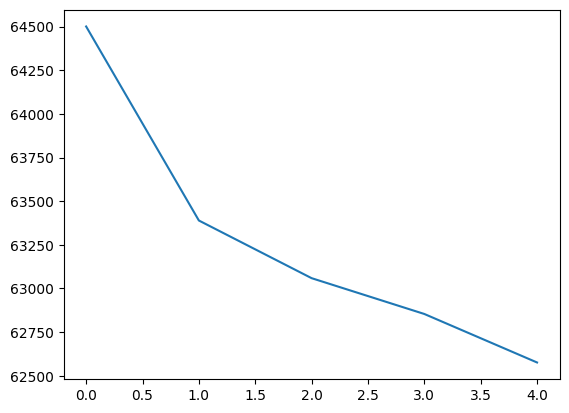

In [105]:
plt.plot(range(len(train_elbo)), train_elbo)

plt.show()

In [106]:
for key, value in prod_slda.beta_meta().items():
    print(key, F.softmax(value,-1))

pos_bigrams tensor([[0.0026, 0.0024, 0.0020,  ..., 0.0033, 0.0011, 0.0023],
        [0.0027, 0.0034, 0.0038,  ..., 0.0035, 0.0041, 0.0037],
        [0.0025, 0.0032, 0.0038,  ..., 0.0035, 0.0036, 0.0034],
        [0.0027, 0.0032, 0.0030,  ..., 0.0037, 0.0025, 0.0032],
        [0.0028, 0.0032, 0.0033,  ..., 0.0036, 0.0029, 0.0035]])


In [108]:
path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
prod_slda.eval()
torch.save(prod_slda, path)
# pyro.clear_param_store()
# prod_slda = torch.load(path)
print(f'Saved to {path}')

Saved to /burg/nlp/users/zfh2000/style_results/pos_bigrams/2023-12-14_17_54_45/model_epoch5_20914.218841552734.pt
